In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pathlib, json
import torch
import os
import pandas as pd
import numpy as np
import pickle, sys
import warnings
from tqdm import tqdm
from sklearn.model_selection import KFold

sys.path.append('../')
sys.path.append('../../')

from recipes.dataset import MCPASDataset
import warnings
warnings.filterwarnings('ignore')

# from analysis_util import display_mat_from_ind
# from analysis_util import convert_len

from Bio.PDB import *

from pdb_util import get_chain_list, calc_dist, remove_HOH #, get_structure_from_id
# get_structure_from_id, from_str_to_chain_names, get_residues_from_names
# from pdb_util import get_cdrs_from_anarci
# from pdb_util import get_seqs_from_residues
warnings.filterwarnings(action='once')


def display_mat_from_ind(ind, wantdisplay=False):
    attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]
    aseq = DF_TCR.iloc[ind]['tcra']
    bseq = DF_TCR.iloc[ind]['tcrb']
    abseq = convert_len(aseq, MAXLENGTH_A) + convert_len(bseq, MAXLENGTH_B)
    peptide = convert_len(DF_TCR.iloc[ind]['peptide'], max_len_epitope)


    attn_output_weights2_list = []
    for head_i in range(4):
        a = attn_output_weights2[head_i]
        dfa = pd.DataFrame(a)
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.columns = [f'{c}_{i}' for i,c in enumerate(list(abseq_with_comma))]
        dfa = dfa.head(len(peptide.replace('8','')))
        dfa.index = list(peptide.replace('8',''))
        dfa.index = [f'{ind}_{i}' for i,ind in enumerate(dfa.index)]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights2_list.append(dfa)

    abseq_index = convert_len(aseq, MAXLENGTH_A) + ':' + convert_len(bseq, MAXLENGTH_B)

    attn_output_weights1_list = []
    for head_i in range(4):
        a = attn_output_weights1[head_i]
        dfa = pd.DataFrame(a).T
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.T
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(list(abseq_index))]

        dfa.columns = [f'{ind}_{i}' for i,ind in enumerate(peptide)]
        selector_columns = [c for c in dfa.columns if '8_' not in c]
        selector_index = [c for c in dfa.index if '8_' not in c]
        dfa = dfa.loc[selector_index]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(abseq_with_comma)]
        dfa = dfa[selector_columns]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights1_list.append(dfa)
    return attn_output_weights1_list, attn_output_weights2_list

def convert_len(seq, maxlen):
    if len(seq) >= maxlen:
        return seq[:maxlen]
    else:  # padding
        pad = '8' * int(maxlen - len(seq))
        return seq + pad
    


def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk


def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

def split_and_get_first(a):
    if ',' in a:
        a = a.split(',')[0]
    return a


In [3]:
!find ../ -name aa_codes.csv 

..//analysis/aa_codes.csv


In [4]:
# dt = "20211029_011638" #logdf.checkp[0].split('/')[-1]

dt = '20220211_191954'

In [5]:
!find ./ -name "20220211_191954_attention_matrix_dict.pickle"

In [6]:
AACODES = pd.read_csv('../analysis/aa_codes.csv')
AACODES['Abbreviation'] = AACODES['Abbreviation'].apply(lambda a: a.upper())
AACODES_DICT = {row['Abbreviation']:row['1 letter abbreviation'] for i, row in AACODES.iterrows()}

KFOLD_I = 0

print('dt', dt)
OUT_DIR = '../analysis/../../../tcr_attention_cachedir'
ATTENTION_MATRIX_DICT = pickle.load(open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle','rb'))
# attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]

p_list = [f"../analysis/../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
          f"../analysis/../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle", 
          f'../analysis/../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle',
          f'../analysis/../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle',]
df_all = get_df_from_path(p_list)

print("df_all(train).value_counts() \n\t", df_all.sign.value_counts().to_dict())
kf = KFold(n_splits=5, shuffle=True, random_state=2)
train_index, valid_index = [
    (train_index, valid_index) for train_index, valid_index in kf.split(df_all)
][KFOLD_I]
df_train, df_valid = df_all.loc[train_index], df_all.loc[valid_index]

DF_TCR = df_train = remove_UNK_and_take_subset(df_train)
dataset_train, dataset_valid = MCPASDataset(df_train), MCPASDataset(df_valid)

print('len(dataset_train),', len(dataset_train), len(df_train))


dt 20220211_191954


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/2703507308.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../analysis/../../../tcr_attention_cachedir/20220211_191954_attention_matrix_dict.pickle'>
  ATTENTION_MATRIX_DICT = pickle.load(open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle','rb'))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/2577082965.py:91: ResourceWarning: unclosed file <_io.BufferedReader name='../analysis/../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle'>
  return pd.DataFrame(pickle.load(open(datapath, "rb")))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/2577082965.py:91: ResourceWarning: unclosed file <_io.BufferedReader name='../analysis/../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle'>
  return pd.DataFrame(pickle.load(open(datapath, "rb")))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/2577082965.py:91: ResourceWarning: unclosed file <_io.Buffer

df_all(train).value_counts() 
	 {0: 291315, 1: 58263}
df_nounk.value_counts() 
	  {0: 116876, 1: 23335}
df_nounk.drop_duplicates('tcrb') 
	  {0: 15358, 1: 3752}
datasize and y-vcounts:  (140211, 11) 0    116876
1     23335
Name: sign, dtype: int64
datasize and y-vcounts:  (35000, 11) 0    29212
1     5788
Name: sign, dtype: int64
len(dataset_train), 140211 140211


../recipes/dataset.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sign'] = df['sign'].astype(int)


# SCEPTRE

In [3]:
pd.read_csv('/Users/kyoheikoyama/Downloads/sceptre_result_v2.csv')['pdb_id'].nunique()

119

In [4]:
pd.read_csv('/Users/kyoheikoyama/Downloads/sceptre_result_v2.csv')['pdb_id'].unique()

array(['2P5E', '2P5W', '2PYE', '3C60', '5HHO', '5E9D', '1D9K', '5KS9',
       '4GG6', '4JFD', '4JFF', '4JFE', '1ZGL', '5WLG', '4JRX', '4JRY',
       '3QEQ', '3QDM', '4FTV', '3E2H', '2F54', '2BNQ', '2BNR', '2F53',
       '3MBE', '4P5T', '1MI5', '5NMG', '5NME', '5NMF', '6V13', '6V15',
       '4MJI', '3E3Q', '2AK4', '3KXF', '2WBJ', '1YMM', '2E7L', '3MV8',
       '4PRI', '4PRH', '3MV9', '3MV7', '4PRP', '3O6F', '3PL6', '4MAY',
       '4GRL', '5SWZ', '1KJ2', '5KSA', '5MEN', '2NX5', '5D2L', '5D2N',
       '3QIB', '4P2O', '4OZG', '4P4K', '4L3E', '2PXY', '2J8U', '2JCC',
       '2UWE', '1LP9', '1FYT', '4Y19', '5BRZ', '5BS0', '3KPS', '3KPR',
       '3PQY', '1QRN', '1QSF', '6PX6', '3QIU', '3QIW', '4P23', '4P46',
       '3VXR', '3VXS', '3W0W', '3VXU', '4OZH', '4OZI', '4Z7W', '3HG1',
       '4QOK', '5SWS', '5WKF', '5WKH', '5EU6', '3TJH', '3TPU', '3TFK',
       '3TF7', '3GSN', '5E6I', '6AVF', '3QDG', '3QDJ', '3DXA', '2CKB',
       '1MWA', '1G6R', '2OI9', '4P2Q', '4P2R', '3C6L', '4Z7U', '5EUO',
      

In [5]:
def tcr_a_or_b(row):
    if row['chain1_type'] == 'alpha':
        return pd.Series({'tcra_seq': row['chain1_cdr3_seq_calculated'], 
         'tcrb_seq': row['chain2_cdr3_seq_calculated']})
    else: #if row['chain1_type'] == 'beta':
        return pd.Series({'tcrb_seq': row['chain1_cdr3_seq_calculated'], 
         'tcra_seq': row['chain2_cdr3_seq_calculated']})

df_sceptre_result = pd.read_csv('../analysis/../sceptre_result.csv')

df_sceptre_result = df_sceptre_result[[
    'chain1_type', 'chain2_type', 'chain1_cdr3_seq_calculated', 'chain2_cdr3_seq_calculated', 
    'epitope_seq', 'epitope_accession_IRI', 'epitope_organism_IRI', 
    'pdb_id', 'tcr_c1_pdb_chain', 'tcr_c2_pdb_chain', 'mhc_c1_pdb_chain', 'mhc_c2_pdb_chain', 'e_pdb_chain', 'pdb_cell_contact_area', 'chain1_cdr3_pdb_pos', 'chain2_cdr3_pdb_pos',
    'calc_e_residues', 'calc_e_tcr_residues', 'calc_e_mhc_residues', 'calc_tcr_e_residues', 'calc_tcr_mhc_residues', 'calc_mhc_e_residues', 'calc_mhc_tcr_residues', 'calc_e_contact_area', 'calc_cell_contact_area'
                                      ]]
df_sceptre_result = pd.concat([
    df_sceptre_result,
    pd.DataFrame(df_sceptre_result.apply(tcr_a_or_b, axis=1))], axis=1)


In [7]:
df_sceptre_result

chain1_type chain2_type chain1_cdr3_seq_calculated  \
0        alpha        beta              AVRPLLDGTYIPT   
1        alpha        beta              AVRPLLDGTYIPT   
2        alpha        beta              AVRPLLDGTYIPT   
3        alpha        beta                 AGAGSQGNLI   
4        alpha        beta                AVTKYSWGKLQ   
..         ...         ...                        ...   
75       alpha        beta              AGAIGPSNTGKLI   
76       alpha        beta                  AEDNNARLM   
77        beta         NaN              ASSLEGGYYNEQF   
78       alpha        beta                   LVVDQKLV   
79       alpha        beta                 AFDTNAGKST   

   chain2_cdr3_seq_calculated    epitope_seq  \
0                ASSYLGNTGELF      SLLMWITQC   
1                ASSYLGNTGELF      SLLMWITQC   
2                ASSYLGNTGELF      SLLMWITQC   
3                 ASSIRSSYEQY      GILEFVFTL   
4              ASRPGWMAGGVELY     ELAGIGILTV   
..                        ...            ...   
75                ASSIRSSYEQY      GILGFVFTL   
76                SARDGTGNGYT      GLCTLVAML   
77          ALGELAGAGGTSYGKLT      IPSINVHHY   
78              ASSGGHTGSNEQF  APRGPHGGAASGL   
79                ASSIFGQREQY      GILGFVFTL   

                             epitope_accession_IRI  \
0     http://www.ncbi.nlm.nih.gov/protein/P78358.1   
1     http://www.ncbi.nlm.nih.gov/protein/P78358.1   
2     http://www.ncbi.nlm.nih.gov/protein/P78358.1   
3   http://www.ncbi.nlm.nih.gov/protein/ACN59839.1   
4                                              NaN   
..                                             ...   
75    http://www.ncbi.nlm.nih.gov/protein/P03485.1   
76  http://www.ncbi.nlm.nih.gov/protein/CAD53409.1   
77  http://www.ncbi.nlm.nih.gov/protein/AAA45994.1   
78    http://www.ncbi.nlm.nih.gov/protein/P78358.1   
79      http://www.ncbi.nlm.nih.gov/protein/Q58CE8   

                               epitope_organism_IRI pdb_id tcr_c1_pdb_chain  \
0     http://purl.obolibrary.org/obo/NCBITaxon_9606   2P5E                D   
1     http://purl.obolibrary.org/obo/NCBITaxon_9606   2P5W                D   
2     http://purl.obolibrary.org/obo/NCBITaxon_9606   2PYE                D   
3   http://purl.obolibrary.org/obo/NCBITaxon_616922   5HHO                D   
4                                               NaN   5E9D                D   
..                                              ...    ...              ...   
75   http://purl.obolibrary.org/obo/NCBITaxon_11320   5EUO                E   
76   http://purl.obolibrary.org/obo/NCBITaxon_10376   3O4L                D   
77   http://purl.obolibrary.org/obo/NCBITaxon_10359   4QRR                E   
78    http://purl.obolibrary.org/obo/NCBITaxon_9606   6AVG                C   
79   http://purl.obolibrary.org/obo/NCBITaxon_11320   5ISZ                D   

   tcr_c2_pdb_chain  ...              calc_e_tcr_residues  \
0                 E  ...            C: M4, W5, I6, T7, Q8   
1                 E  ...            C: M4, W5, I6, T7, Q8   
2                 E  ...            C: M4, W5, I6, T7, Q8   
3                 E  ...                C: E4, F5, V6, T8   
4                 E  ...            C: G4, I5, I7, L8, T9   
..              ...  ...                              ...   
75                F  ...        J: I2, L3, G4, F5, V6, T8   
76                E  ...        C: C3, T4, L5, V6, A7, M8   
77                D  ...                P: I4, V6, H7, H8   
78                D  ...  P: P5, H6, G7, G8, A9, A10, S11   
79                E  ...    C: I2, L3, G4, F5, V6, F7, T8   

                           calc_e_mhc_residues  \
0            C: S1, L2, L3, M4, I6, T7, Q8, C9   
1            C: S1, L2, L3, M4, I6, T7, Q8, C9   
2            C: S1, L2, L3, M4, I6, T7, Q8, C9   
3        C: G1, I2, L3, E4, F5, V6, F7, T8, L9   
4   C: E1, L2, A3, G4, I5, G6, I7, L8, T9, V10   
..                                         ...   
75       J: G1, I2, L3, G4, F5, V6, F7, T8, L9   
76       C

In [6]:
print(len(df_sceptre_result))

80


# Attention based analysis

In [10]:
# DF_TCR[DF_TCR['peptide'] == PEPSEQ].head(3)

In [11]:
MAXLENGTH_A, MAXLENGTH_B, max_len_epitope = 28, 28, 25

In [12]:
import plotly.express as px

In [13]:
# attn_output_weights1_list, attn_output_weights2_list = display_mat_from_ind(ind)

In [14]:
# os.system(f'aws s3 cp s3://sg-playground-kkoyama-temp/tcrpred/tcr_attention_cachedir/df_pep_{PEPSEQ}.parquet ../../../tcr_attention_cachedir/')

# df_pep = pd.read_parquet(f'../../../tcr_attention_cachedir/df_pep_{PEPSEQ}.parquet')



# PDB based analysis

## Look at the "auth id"

In [15]:
PDBENTRIES = [s.replace('pdb','').replace('.ent','').upper() 
              for s in os.listdir('/Users/kyoheikoyama/workspace/tcrpred/analysis/analysis1_alldata/pdb/')]

print('len(PDBENTRIES)', len(PDBENTRIES))

len(PDBENTRIES) 895


In [16]:
# def get_structure_from_id(ent):
#     structure = parser.get_structure("PHA-L", "1FAT.pdb")

In [17]:
# %%time

import  multiprocessing as mp
saved_list =  [a.replace('.ent','').replace('pdb','').upper() for a in os.listdir('pdb')]

pickleload = lambda p: pickle.load(open(p,"rb"))

path = "/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/2021_DICT_PDBID_2_CHAINNAMES.pickle"
if os.path.exists(path):
    DICT_PDBID_2_CHAINNAMES = pickleload(path)
    DICT_PDBID_2_RESIDUES = pickleload("/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/2021_DICT_PDBID_2_RESIDUES.pickle")
    DICT_PDBID_2_RESIDUES = {k:[remove_HOH(v) for v in vv] for k,vv in DICT_PDBID_2_RESIDUES.items()}
else:
    # DICT_PDBID_2_STRUCTURE = {pdbid:get_structure_from_id(pdbid) for pdbid in tqdm(PDBENTRIES)}
    with mp.Pool(4) as p:
        structs = p.map(get_structure_from_id, PDBENTRIES)

    DICT_PDBID_2_STRUCTURE = {pdbid:s for pdbid, s in zip(PDBENTRIES, structs)}

    temp = {pdbid:(from_str_to_chain_names(s)) for pdbid, s in 
                             tqdm(DICT_PDBID_2_STRUCTURE.items())}
    DICT_PDBID_2_CHAINNAMES = {k:v for k, v in temp.items() if v[0] is not None}
    DICT_PDBID_2_RESIDUES = {}
    for p, v in tqdm(DICT_PDBID_2_CHAINNAMES.items()):
        a, b, e = v
        a = split_and_get_first(a)
        b = split_and_get_first(b)
        e = split_and_get_first(e)
        s = DICT_PDBID_2_STRUCTURE[p]
        DICT_PDBID_2_RESIDUES[p]  = get_residues_from_names(s, a, b, e)


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/1420475253.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/2021_DICT_PDBID_2_CHAINNAMES.pickle'>
  pickleload = lambda p: pickle.load(open(p,"rb"))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/1420475253.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/2021_DICT_PDBID_2_RESIDUES.pickle'>
  pickleload = lambda p: pickle.load(open(p,"rb"))


In [18]:
print('count_of_pdbids', len(DICT_PDBID_2_RESIDUES))

count_of_pdbids 79


# USE Anarci to get CDRs of TCR from PDB

https://github.com/oxpig/ANARCI

In [19]:
def res_to_alphabetseq(rlist):
    return ''.join([AACODES_DICT.get(r.get_resname(), 'X') for r in rlist])

    
def get_cdrs_from_anarci(pdbid, residues_chain_alpha, residues_chain_beta):
    _IMGT_CDR_POS = [str(i) for i in range(104, 119)] #
    anarciroot = '/Users/kyoheikoyama/workspace/tcrpred/analysis/analysis1_alldata/anarci'
    cdr_beta = ''.join(
        pd.read_csv(f'{anarciroot}/{pdbid}_anarci_B.csv')[_IMGT_CDR_POS].values[0].tolist())
    cdr_alpha = ''.join(
        pd.read_csv(f'{anarciroot}/{pdbid}_anarci_A.csv')[_IMGT_CDR_POS].values[0].tolist())
    
    seq_alpha = res_to_alphabetseq(residues_chain_alpha)
    seq_beta = res_to_alphabetseq(residues_chain_beta)
    
    cdr_beta_no_hyphen = cdr_beta.replace('-','')
    cdr_alpha_no_hyphen = cdr_alpha.replace('-','')
    cdr_start_pos_alpha = seq_alpha.find(cdr_alpha_no_hyphen)
    cdr_start_pos_beta = seq_beta.find(cdr_beta_no_hyphen)
    residues_chain_cdr_alpha = residues_chain_alpha[cdr_start_pos_alpha:cdr_start_pos_alpha+len(cdr_alpha_no_hyphen)]
    residues_chain_cdr_beta = residues_chain_beta[cdr_start_pos_beta:cdr_start_pos_beta+len(cdr_beta_no_hyphen)]
    return residues_chain_cdr_alpha, residues_chain_cdr_beta
    
# a, b = get_cdr_from_anarci(pdbid, residues_chain_alpha, residues_chain_beta)

In [20]:
%%time
DICT_PDBID_2_CDRS = {}
for pdbid, v in DICT_PDBID_2_RESIDUES.items():
    if pdbid=='5JZI' or pdbid=='4QRR' or pdbid=='5JHD' or pdbid=='2OL3':
        print(f'{pdbid} has only delta-chain and beta-chain' )
        continue
    residues_chain_alpha, residues_chain_beta, epi = v
    residues_chain_cdr_alpha, residues_chain_cdr_beta = \
        get_cdrs_from_anarci(pdbid, residues_chain_alpha, residues_chain_beta)
    DICT_PDBID_2_CDRS[pdbid] = (residues_chain_cdr_alpha, residues_chain_cdr_beta, epi)

5JZI has only delta-chain and beta-chain
4QRR has only delta-chain and beta-chain
5JHD has only delta-chain and beta-chain
2OL3 has only delta-chain and beta-chain
CPU times: user 1.33 s, sys: 32.1 ms, total: 1.36 s
Wall time: 1.4 s


#### http://www.imgt.org/IMGTScientificChart/Nomenclature/IMGT-FRCDRdefinition.html

# PDB-distance-based Visualization
(Distance Matrix on PDB)

In [21]:
# from pdb_util import distance_mat_from_residues

# from pdb_util import get_seqs_from_residues

In [22]:
def distance_mat_from_residues(residues_chain_cdr_alpha, residues_chain_cdr_beta, residues_chain_epitope):
#     cdr_alpha_no_hyphen, cdr_beta_no_hyphen, seq_epitope = get_seqs_from_residues( 
#         residues_chain_cdr_alpha, residues_chain_cdr_beta, residues_chain_epitope)
    cdr_alpha_no_hyphen = res_to_alphabetseq(residues_chain_cdr_alpha)
    cdr_beta_no_hyphen = res_to_alphabetseq(residues_chain_cdr_beta)
    seq_epitope = res_to_alphabetseq(residues_chain_epitope)
    distmat1 = calc_dist(residues_chain_epitope, residues_chain_cdr_beta)
    dist_separate = np.zeros((len(residues_chain_epitope), 1))
    distmat2 = calc_dist(residues_chain_epitope, residues_chain_cdr_alpha)
    distmat = np.c_[distmat2, dist_separate, distmat1]
    distmat = pd.DataFrame(distmat, index=list(make_xlabel(seq_epitope)), 
                           columns=list(make_xlabel(cdr_alpha_no_hyphen + ':' + cdr_beta_no_hyphen)))
    return distmat

def make_xlabel(seq):
    return [f'{s}_{i}' for i,s in enumerate(seq)]

In [23]:
DICT_PDBID_2_DISTANCE = {}

for p,v in DICT_PDBID_2_CDRS.items():
    a,b,e = v
    if any([vv is None or len(vv)==0 for vv in v]):
        continue
    else:
        DICT_PDBID_2_DISTANCE[p] = distance_mat_from_residues(a, b, e)

In [24]:
for i in range(3):
    print([AACODES_DICT[r.get_resname()]  for r in v[i]])

['C', 'A', 'V', 'N', 'V', 'A', 'G', 'K', 'S', 'T', 'F']
['C', 'A', 'W', 'S', 'E', 'T', 'G', 'L', 'G', 'T', 'G', 'E', 'L', 'F', 'F']
['A', 'A', 'G', 'I', 'G', 'I', 'L', 'T', 'V']


In [25]:
len(DICT_PDBID_2_RESIDUES), len(DICT_PDBID_2_CDRS), len(DICT_PDBID_2_DISTANCE)

(79, 75, 57)

In [26]:
import plotly.express as px

# from pdb_util import make_xlabel

DICT_PDBID_2_MELTDIST = {}
for p,distmat in DICT_PDBID_2_DISTANCE.items():
    distmat_vis = distmat.drop(columns=[c for c in distmat.columns if ':' in c])\
        .melt(ignore_index=False).reset_index().rename(columns={'variable':'tcr', 'index':'peptide'})
    distmat_vis = distmat_vis.sort_values(by=['peptide', 'tcr'])
    DICT_PDBID_2_MELTDIST[p] = distmat_vis

In [27]:
for p,distmat in DICT_PDBID_2_DISTANCE.items():
    fig = px.imshow(distmat, 
              x=distmat.columns, 
              y=distmat.index,  
              width=1000, height=1200)
    fig.update_layout(
        title=f"Residue distance in PDB {p}",
        xaxis_title="cdr_alpha:beta",
        yaxis_title="seq_epitope",
        autosize=False
    )
    fig.show()
    break

/Users/kyoheikoyama/.pyenv/versions/miniconda3-latest/envs/tcrpred/lib/python3.8/site-packages/plotly/express/_imshow.py:349: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if img.dtype == np.bool:


# Get attention from adhoc sequence

In [28]:
with open(f"../analysis/../hpo_params/optuna_best.json", "r") as fp:
    hparams = json.load(fp)

In [29]:
def get_seqs_from_residues(a1,b1,c1):
    return [res_to_alphabetseq(a) for a in [a1,b1,c1]]

DICT_PDBID_2_SEQUENCES_CDR = {}
for p, cdrs in DICT_PDBID_2_CDRS.items():
    if any([v is None or len(v)==0 for v in cdrs]):
        continue
    DICT_PDBID_2_SEQUENCES_CDR[p] =  get_seqs_from_residues(*cdrs)


In [30]:
df = pd.DataFrame(DICT_PDBID_2_SEQUENCES_CDR).T
df = df.rename(columns={0:'tcra', 1:'tcrb', 2:'peptide'})
df['sign']=1.0

In [31]:
df.head(3)

tcra             tcrb        peptide  sign
2VLK  CAGAGSQGNLIF    CASSSRSSYEQYF      GILGFVFTL   1.0
2ICW  CAVSGFASALTF      CASGGGGTLYF  PKYVKQNTLKLAT   1.0
5WKF  CGLGDAGNMLTF  CASSLGQGLLYGYTF     GTSGSPIVNR   1.0

In [32]:
df = df[df['peptide'].apply(len)<=25]

In [33]:
len(df)

55

In [34]:
# df = df.reset_index().rename(columns={'index':'pdbid'})

In [35]:
torch_dataset = MCPASDataset(df)
analysis_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=1)

datasize and y-vcounts:  (55, 4) 1    55
Name: sign, dtype: int64


## Recover model weights

In [36]:
from recipes.utils import get_file_paths
from scripts.attention_extractor import get_attention_weights, Explain_TCRModel
from recipes.model import TCRModel
from ignite.handlers import Checkpoint
from ignite.engine import Events, create_supervised_trainer
n_tok = 29  # NUM_VOCAB
n_pos1 = 62  # MAX_LEN_AB
n_pos2 = 26  # MAX_LEN_Epitope
n_seg = 3

d_model, d_ff, n_head,n_local_encoder = hparams['d_model'], hparams['d_ff'], hparams['n_head'], hparams['n_local_encoder']
n_global_encoder = hparams['n_global_encoder']
dropout = hparams['dropout']
batch_size = hparams['batch_size']
lr=hparams['lr']

explain_model = Explain_TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                                 n_tok=n_tok, n_pos1=n_pos1, n_pos2=n_pos2, n_seg=n_seg)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

'''Model, optim, trainer'''
model = TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                 n_tok=n_tok, n_pos1=n_pos1,
                n_pos2=n_pos2, n_seg=n_seg)

# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Loss
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 15.0], device=device))

trainer = create_supervised_trainer(
    model=model, optimizer=optim, loss_fn=loss_fn, device=device,
)

checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if dt in f]
CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'
CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

## Get the prediction and the best model
to_load = {'model': model, 'optimizer': optim, 'trainer': trainer}

torch_check_point_local = '../../../checkpoint/'
fro = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATH)
if not os.path.exists(os.path.join(torch_check_point_local, CHECKPOINT_PATH)):
    os.system(f'''aws s3 cp {fro} {torch_check_point_local}''')
    
checkpoint = torch.load(os.path.join(torch_check_point_local, CHECKPOINT_PATH), map_location=torch.device(device))

checkpoint['trainer']['seed'] = 9

Checkpoint.load_objects(to_load=to_load, checkpoint=checkpoint)


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3345619223.py:39: ResourceWarning:

unclosed <ssl.SSLSocket fd=89, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.2.119', 63912), raddr=('52.217.234.209', 443)>



In [37]:
!aws s3 ls s3://sg-playground-kkoyama-temp/tcrpred/checkpoint/

                           PRE 20210901_021352/
                           PRE 20210907_175614/
                           PRE 20210907_193255/
                           PRE 20210907_193531/
                           PRE 20210908_012715/
                           PRE 20210911_030554/
                           PRE 20210911_030913/
                           PRE 20210911_033545/
                           PRE 20210911_040850/
                           PRE 20210911_043036/
                           PRE 20210911_044036/
                           PRE 20210911_045039/
                           PRE 20210911_050046/
                           PRE 20210911_051047/
                           PRE 20210915_195759/
                           PRE 20210915_200245/
                           PRE 20210915_200505/
                           PRE 20210915_201436/
                           PRE 20210915_201651/
                           PRE 20210915_201838/
                           PRE 20210916_

In [38]:
!aws s3 ls s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/

2021-09-16 02:40:28          0 
2021-10-16 23:01:15       4260 20210802_183459_hh.csv
2021-10-16 23:01:15        402 20210802_183459_yy.csv
2021-10-16 23:01:15       4260 20210802_184559_hh.csv
2021-10-16 23:01:15        402 20210802_184559_yy.csv
2021-10-16 23:01:15       4260 20210803_003725_hh.csv
2021-10-16 23:01:15        402 20210803_003725_yy.csv
2021-10-16 23:01:15       4566 20210803_050213_hh.csv
2021-10-16 23:01:15        402 20210803_050213_yy.csv
2021-10-16 23:01:15       4678 20210803_054135_hh.csv
2021-10-16 23:01:15        402 20210803_054135_yy.csv
2021-10-16 23:01:15       4657 20210805_020608_hh.csv
2021-10-16 23:01:16        402 20210805_020608_yy.csv
2021-10-16 23:01:16       4657 20210805_025710_hh.csv
2021-10-16 23:01:16        402 20210805_025710_yy.csv
2021-10-16 23:01:16       4657 20210805_030119_hh.csv
2021-10-16 23:01:16        402 20210805_030119_yy.csv
2021-10-16 23:01:16       4608 20210816_233119_hh.csv
2021-10-16 23:01:16        402 20210816_233119_yy.

2021-10-29 03:28:25      70578 20211029_011638_k3_test_yy.csv
2021-10-29 03:28:26 1585454844 20211029_011638_results_attention_tes.pickle
2021-10-29 03:29:11 5037664728 20211029_011638_results_attention_tra.pickle
2021-10-29 03:30:29 1248936607 20211029_011638_results_attention_val.pickle
2021-10-29 03:30:44    3654702 20211029_011642_k4_datasettest.csv
2021-10-29 03:30:45     731643 20211029_011642_k4_test_hh.csv
2021-10-29 03:30:45      70578 20211029_011642_k4_test_yy.csv
2021-10-29 03:30:46 1585454844 20211029_011642_results_attention_tes.pickle
2021-10-29 03:30:46 5024635310 20211029_011642_results_attention_tra.pickle
2021-10-29 03:32:05 1261966016 20211029_011642_results_attention_val.pickle
2021-10-29 03:32:43    2759029 20211029_020248_k4_datasettest.csv
2021-10-29 03:32:44     656115 20211029_020248_k4_test_hh.csv
2021-10-29 03:32:44      62208 20211029_020248_k4_test_yy.csv
2021-10-29 03:32:44 1397426963 20211029_020248_results_attention_tes.pickle
2021-10-29 03:32:44 111796

In [39]:
MAXLENGTH_B

28

In [40]:
def get_mat_from_result_tuple(result_tuple, aseq, bseq, peptide, showplot=False):
    #abseq = convert_len(aseq, MAXLENGTH_A)convert_len(bseq, MAXLENGTH_B) 
    attn_output_weights1 = result_tuple[0]
    attn_output_weights2 = result_tuple[1]
    print(f"aseq={aseq}, bseq={bseq}, peptide={peptide}")
    abseq_with_comma = f'{aseq}:{bseq}'
    abseq_index = convert_len(aseq, MAXLENGTH_A) + ':' + convert_len(bseq, MAXLENGTH_B) 
    
    attn_output_weights2_list = []
    for head_i in range(4):
#         print('head', head_i, attn_output_weights2[head_i].shape)
        a = attn_output_weights2[head_i]
        dfa = pd.DataFrame(a)
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.columns = list(abseq_with_comma)
        dfa.columns = [f'{c}_{i}' for i,c in enumerate(dfa.columns)]
        dfa = dfa.head(len(peptide.replace('8','')))
        dfa.index = list(peptide.replace('8',''))
        dfa.index = [f'{ind}_{i}' for i,ind in enumerate(dfa.index)]    
        #         print('df.sum(axis=0)', dfa.sum(axis=0))
        #         print('df.sum(axis=1)', dfa.sum(axis=1))
        # display(px.imshow(dfa, width=800, height=480))
        
        if showplot:
            axs[0,head_i].imshow(dfa, aspect='equal')
            axs[0,head_i].set_xticks(range(len(dfa.columns)))
            axs[0,head_i].set_yticks(range(len(dfa.index)))
            axs[0,head_i].set_xticklabels(dfa.columns)
            axs[0,head_i].set_yticklabels(dfa.index)
        attn_output_weights2_list.append(dfa)
    
    attn_output_weights1_list = []
    for head_i in range(4):
#         print('head', head_i, attn_output_weights1[head_i].shape)
        a = attn_output_weights1[head_i]
        dfa = pd.DataFrame(a).T
        dfa.insert(MAXLENGTH_A, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.T
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.index = list(abseq_index)
        dfa.index = [f'{c}_{i}' for i,c in enumerate(dfa.index)]
        dfa.columns = list(convert_len(peptide, len(dfa.columns)))
        dfa.columns = [f'{ind}_{i}' for i,ind in enumerate(dfa.columns)]
        selector_columns = [c for c in dfa.columns if '8_' not in c]
        selector_index = [c for c in dfa.index if '8_' not in c]
        dfa = dfa.loc[selector_index]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(abseq_with_comma)]
        dfa = dfa[selector_columns]
        #         print('df.sum(axis=0)', dfa.sum(axis=0))
        #         print('df.sum(axis=1)', dfa.sum(axis=1))
        # display(px.imshow(dfa, width=800, height=480))
        if showplot:
            axs[1,head_i].imshow(dfa, aspect='equal')
            axs[1,head_i].set_xticks(range(len(dfa.columns)))
            axs[1,head_i].set_yticks(range(len(dfa.index)))
            axs[1,head_i].set_xticklabels(dfa.columns)
            axs[1,head_i].set_yticklabels(dfa.index)
        attn_output_weights1_list.append(dfa)
    return attn_output_weights1_list, attn_output_weights2_list

In [41]:
len(set([s[2] for s in DICT_PDBID_2_SEQUENCES_CDR.values()])), len(DICT_PDBID_2_SEQUENCES_CDR) 
len(set([s[0] for s in DICT_PDBID_2_SEQUENCES_CDR.values()])), len(DICT_PDBID_2_SEQUENCES_CDR) 

(41, 57)

In [42]:
DICT_PDBID_2_model_out = {}

for p, (xx,yy) in zip(df.index, analysis_loader):
    result_tuple = get_attention_weights([x.to(device) for x in xx], 
                                   model, explain_model=explain_model, device=device)
    DICT_PDBID_2_model_out[p] = result_tuple

In [43]:
# DICT_PDBID_2_model_out

In [44]:
df.index

Index(['2VLK', '2ICW', '5WKF', '2VLJ', '3PQY', '4MJI', '4P2Q', '2YPL', '5BRZ',
       '6RPB', '1J8H', '4P2R', '5MEN', '3MV8', '4OZF', '3VXR', '3VXS', '4OZG',
       '3MV9', '5TEZ', '2J8U', '6Q3S', '4JRX', '5WLG', '3VXU', '1U3H', '4JRY',
       '4Z7V', '2UWE', '1LP9', '3W0W', '6AVF', '2BNQ', '4JFE', '4JFD', '3QIU',
       '6AVG', '2Z31', '2BNR', '5ISZ', '5KS9', '3MV7', '3MBE', '4OZH', '2NX5',
       '5NHT', '4QOK', '5D2L', '1D9K', '1FYT', '4P2O', '5WKH', '6EQB', '2VLR',
       '6EQA'],
      dtype='object')

In [45]:
%%time
from matplotlib import pyplot as plt
showplt = False
DICT_PDBID_2_Atten12 = {}
for p, (xx,yy) in zip(df.index, analysis_loader):
    
    if p not in DICT_PDBID_2_model_out:
        continue
    print('pdbid =', p)
    HEAD_COUNT = 4
    if showplt:
        fig, axs = plt.subplots(2, 4, figsize=(60,16))
    
    a,b,e = DICT_PDBID_2_SEQUENCES_CDR[p]
    attn_output_weights1_list, attn_output_weights2_list = get_mat_from_result_tuple(
        result_tuple=DICT_PDBID_2_model_out[p], aseq=a, bseq=b, peptide=e)
    DICT_PDBID_2_Atten12[p] = (attn_output_weights1_list, attn_output_weights2_list)
    
    if showplt:
        plt.show()
    print('-'*100)    

pdbid = 2VLK
aseq=CAGAGSQGNLIF, bseq=CASSSRSSYEQYF, peptide=GILGFVFTL
----------------------------------------------------------------------------------------------------
pdbid = 2ICW
aseq=CAVSGFASALTF, bseq=CASGGGGTLYF, peptide=PKYVKQNTLKLAT
----------------------------------------------------------------------------------------------------
pdbid = 5WKF
aseq=CGLGDAGNMLTF, bseq=CASSLGQGLLYGYTF, peptide=GTSGSPIVNR
----------------------------------------------------------------------------------------------------
pdbid = 2VLJ
aseq=CAGAGSQGNLIF, bseq=CASSSRSSYEQYF, peptide=GILGFVFTL
----------------------------------------------------------------------------------------------------
pdbid = 3PQY
aseq=CILSGGSNYKLTF, bseq=CASSFGREQYF, peptide=SSLENFRAYV
----------------------------------------------------------------------------------------------------
pdbid = 4MJI
aseq=CATDDDSARQLTF, bseq=CASSLTGGGELFF, peptide=TAFTIPSI
----------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
pdbid = 4P2O
aseq=CAALRATGGNNKLTF, bseq=CASSLNWSQDTQYF, peptide=PADPLAFFSSAIKGGGGSLV
----------------------------------------------------------------------------------------------------
pdbid = 5WKH
aseq=CGLGDAGNMLTF, bseq=CASSLGQGLLYGYTF, peptide=GTSGSPIINR
----------------------------------------------------------------------------------------------------
pdbid = 6EQB
aseq=CAVNDGGRLTF, bseq=CAWSETGLGMGGWQF, peptide=AAGIGILTV
----------------------------------------------------------------------------------------------------
pdbid = 2VLR
aseq=CAGAGSQGNLIF, bseq=CASSSRASYEQYF, peptide=GILGFVFTL
----------------------------------------------------------------------------------------------------
pdbid = 6EQA
aseq=CAVNVAGKSTF, bseq=CAWSETGLGTGELFF, peptide=AAGIGILTV
----------------------------------------------------------------------------------------------------
CPU times: user 1.86 s, 

# Attention-based Visualization

In [46]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

In [47]:
# %%writefile -a analysis_util.py
def calc_melt_df(distmat_vis, attn_output_weights1, attn_output_weights2):
    separator = [c for c in attn_output_weights2.columns if ':' in c][0]
    separator_pos = attn_output_weights2.columns.get_loc(separator)
    removers = [':', 'C_0'] + \
        [attn_output_weights2.columns[i] for i in [separator_pos, separator_pos-1, separator_pos+1, len(attn_output_weights2.columns)-1]]
    remove_col = [c for c in attn_output_weights2.columns if c in removers]
    remove_ind = [c for c in attn_output_weights1.index if c in removers]
    attn_output_weights2 = attn_output_weights2.drop(columns=remove_col)
    attn_output_weights1 = attn_output_weights1.drop(index=remove_ind)
    
    attn_output_weights2_vis = attn_output_weights2.melt(ignore_index=False).reset_index().rename(columns={'variable':'tcr', 'index':'peptide'})
    attn_output_weights2_vis= attn_output_weights2_vis.sort_values(by=['peptide', 'tcr'])
    attn_output_weights1_vis = attn_output_weights1.T.melt(ignore_index=False).reset_index().rename(columns={'variable':'tcr', 'index':'peptide'})
    attn_output_weights1_vis = attn_output_weights1_vis.sort_values(by=['peptide', 'tcr'])
    
    merged_xy_1 = pd.merge(distmat_vis, attn_output_weights1_vis, on=['peptide','tcr'], how='inner')
    merged_xy_2 = pd.merge(distmat_vis, attn_output_weights2_vis, on=['peptide','tcr'], how='inner')
    return merged_xy_1, merged_xy_2



In [48]:
# %%writefile -a analysis_util.py

def show_correlation(distmat_vis, merged_xy_1, merged_xy_2, head):
    #merged_xy_1, merged_xy_2 = calc_melt_df(distmat_vis, attn_output_weights2, attn_output_weights1)
    assert len(merged_xy_2)!=0
    assert len(merged_xy_1)!=0
#     display(merged_xy_2)
#     display(merged_xy_1)
    x = merged_xy_2['value_x'].values
    y = merged_xy_2['value_y'].values
    b2, m2 = polyfit(x, y, 1)
    axs[0, head].plot(x, b2 + m2 * x, '-')
    axs[0, head].scatter(x, y)
    axs[0, head].set_xlabel('distance in PDB')
    axs[0, head].set_ylabel('attention weight value')
    axs[0, head].set_title(f'correlation b/w distance and attention \n (given a PEP, distribute tcr values to the sum 1.0), head {head} \n y={b2:.3f}+{m2:.3f}* x')
    
    x = merged_xy_1['value_x'].values
    y = merged_xy_1['value_y'].values
    b1, m1 = polyfit(x, y, 1)
    axs[1, head].plot(x, b1 + m1 * x, '-')
    axs[1, head].scatter(x, y)
    axs[1, head].set_xlabel('distance in PDB')
    axs[1, head].set_ylabel('attention weight value')
    axs[1, head].set_title(f'correlation b/w distance and attention \n (given a TCR, distribute pep values to the sum 1.0), head {head} \n y={b1:.3f}+{m1:.3f}* x')
    return (b1,m1,b2,m2)
    


('2VLK', 'CAGAGSQGNLIF', 'CASSSRSSYEQYF', 'GILGFVFTL')
aseq=CAGAGSQGNLIF, bseq=CASSSRSSYEQYF, peptide=GILGFVFTL


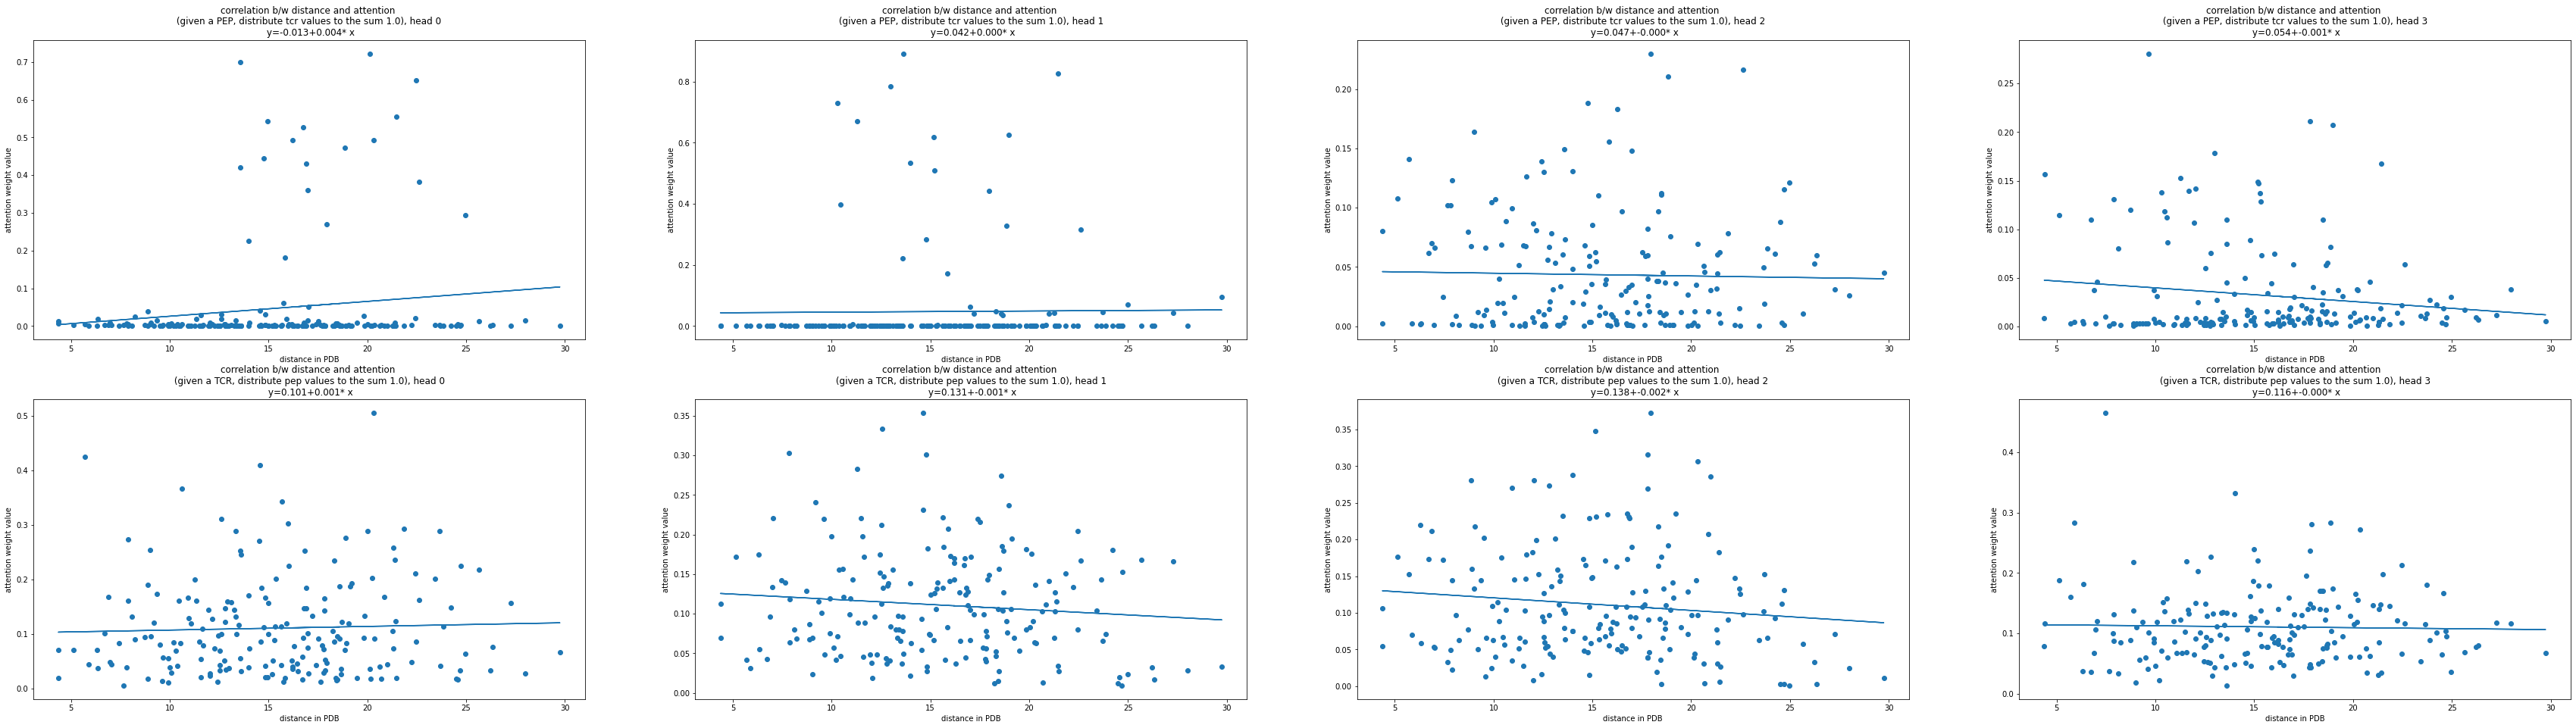

In [49]:
def position_sorted(values):
    sorted_values = sorted(set([c.split('_')[1]+'_'+c.split('_')[0] for c in values]))
    return sorted_values

m1_list = []
m2_list = []

HEAD_COUNT = 4
for p in DICT_PDBID_2_model_out.keys():
    a,b,e = DICT_PDBID_2_SEQUENCES_CDR[p]
    print((p,a,b,e))

    attn_output_weights1_list, attn_output_weights2_list = get_mat_from_result_tuple(
        result_tuple=DICT_PDBID_2_model_out[p], aseq=a, bseq=b, peptide=e)

    fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
    for head in range(HEAD_COUNT):
        distmat_vis = DICT_PDBID_2_MELTDIST[p]
        assert all(attn_output_weights1_list[head].index == attn_output_weights2_list[head].columns)
        no_comma_position_sorted = [c for c in position_sorted(attn_output_weights1_list[head].index) if ':' not in c]
        assert position_sorted(distmat_vis['tcr'].values) == no_comma_position_sorted
        attn_output_weights1, attn_output_weights2 = attn_output_weights1_list[head], attn_output_weights2_list[head]
        merged_xy_1, merged_xy_2 = calc_melt_df(distmat_vis, attn_output_weights1, attn_output_weights2)
        b1,m1,b2,m2 = show_correlation(distmat_vis, merged_xy_1, merged_xy_2, head)
        m1_list.append(m1)
        m2_list.append(m2)
    plt.show()
    break

<AxesSubplot:>

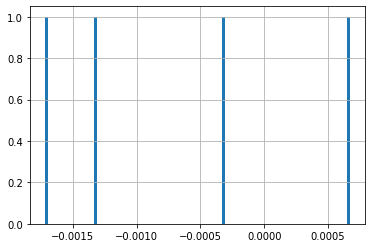

In [50]:
pd.Series(m1_list).hist(bins=100)

In [51]:
pd.Series(m1_list).describe()

count    4.000000
mean    -0.000668
std      0.001070
min     -0.001717
25%     -0.001415
50%     -0.000813
75%     -0.000067
max      0.000670
dtype: float64

<AxesSubplot:>

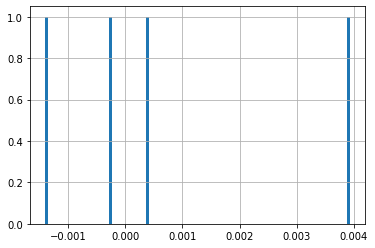

In [52]:
pd.Series(m2_list).hist(bins=100)

## Example of correlation visualization

In [53]:
DICT_PDBID_2_SEQUENCES_CDR.keys()

dict_keys(['2VLK', '2ICW', '5WKF', '5NQK', '2VLJ', '3PQY', '4MJI', '4P2Q', '2YPL', '5BRZ', '6RPB', '1J8H', '4P2R', '5MEN', '3MV8', '4OZF', '3VXR', '3VXS', '4OZG', '3MV9', '5TEZ', '2J8U', '3PL6', '6Q3S', '4JRX', '5WLG', '3VXU', '1U3H', '4JRY', '4Z7V', '2UWE', '1LP9', '3W0W', '6AVF', '2BNQ', '4JFE', '4JFD', '3QIU', '6AVG', '2Z31', '2BNR', '5ISZ', '5KS9', '3MV7', '3MBE', '4OZH', '2NX5', '5NHT', '4QOK', '5D2L', '1D9K', '1FYT', '4P2O', '5WKH', '6EQB', '2VLR', '6EQA'])

('3MV7', 'CAVQDLGTSGSRLTF', 'CASSARSGELFF', 'HPVGEADYFEY')
aseq=CAVQDLGTSGSRLTF, bseq=CASSARSGELFF, peptide=HPVGEADYFEY


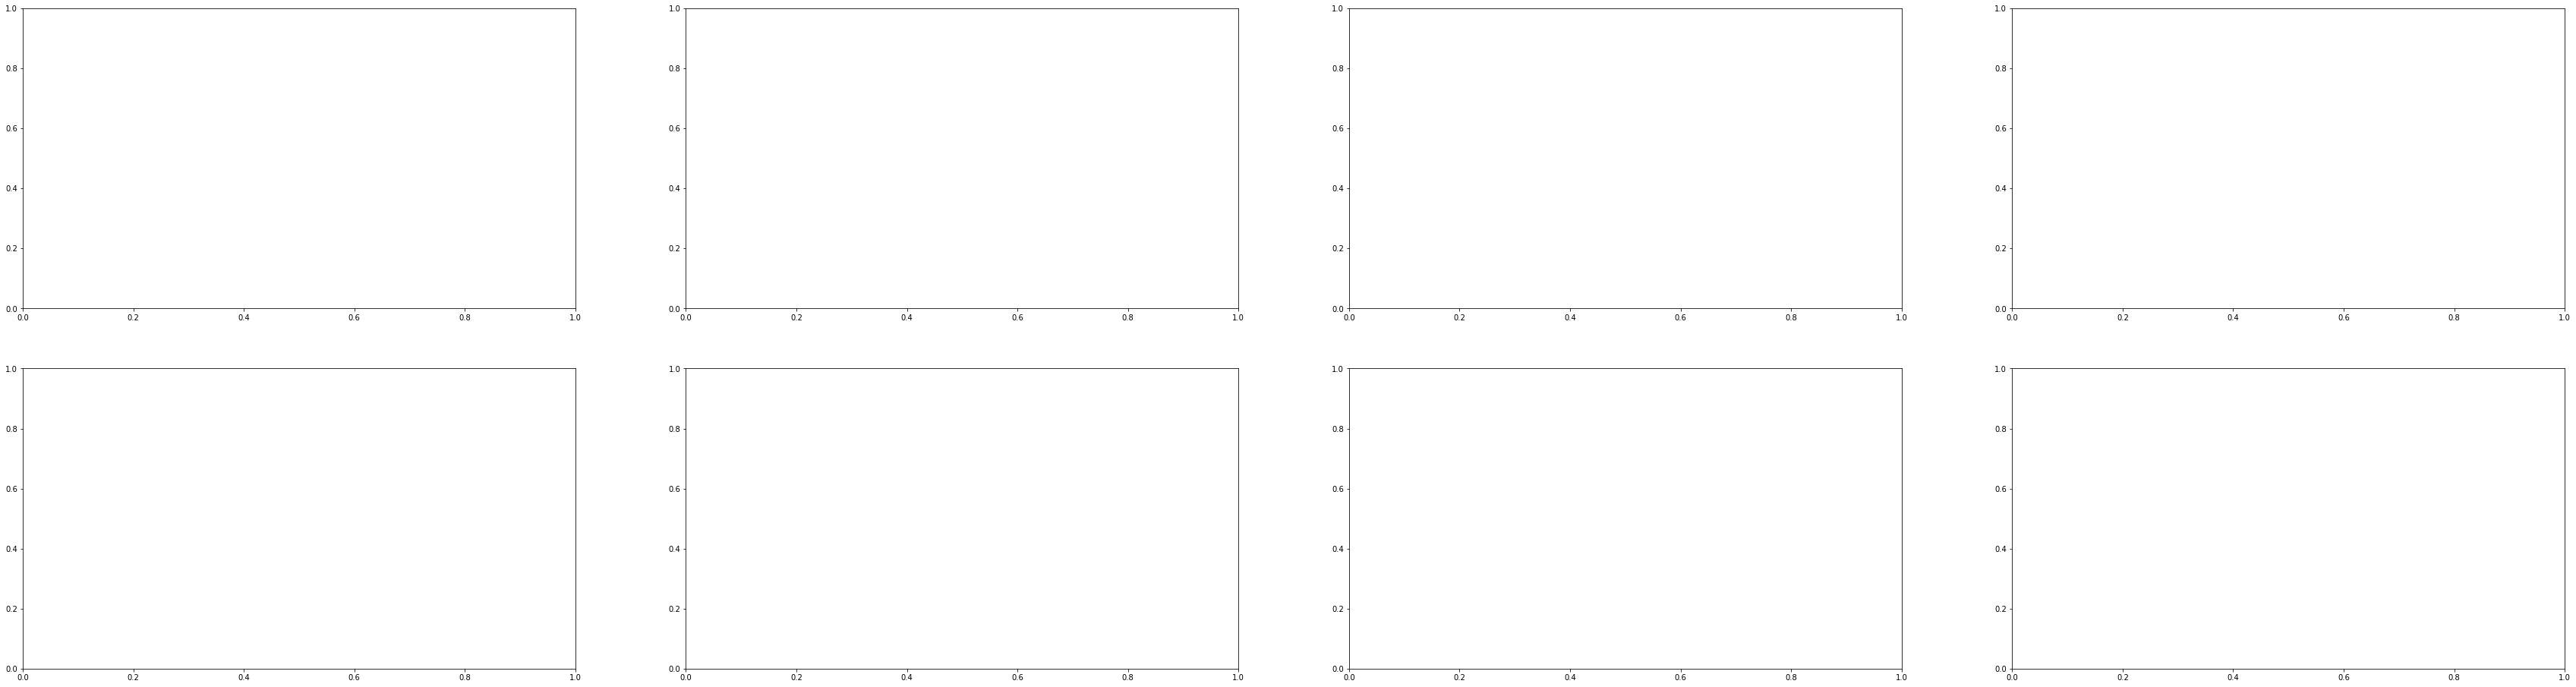

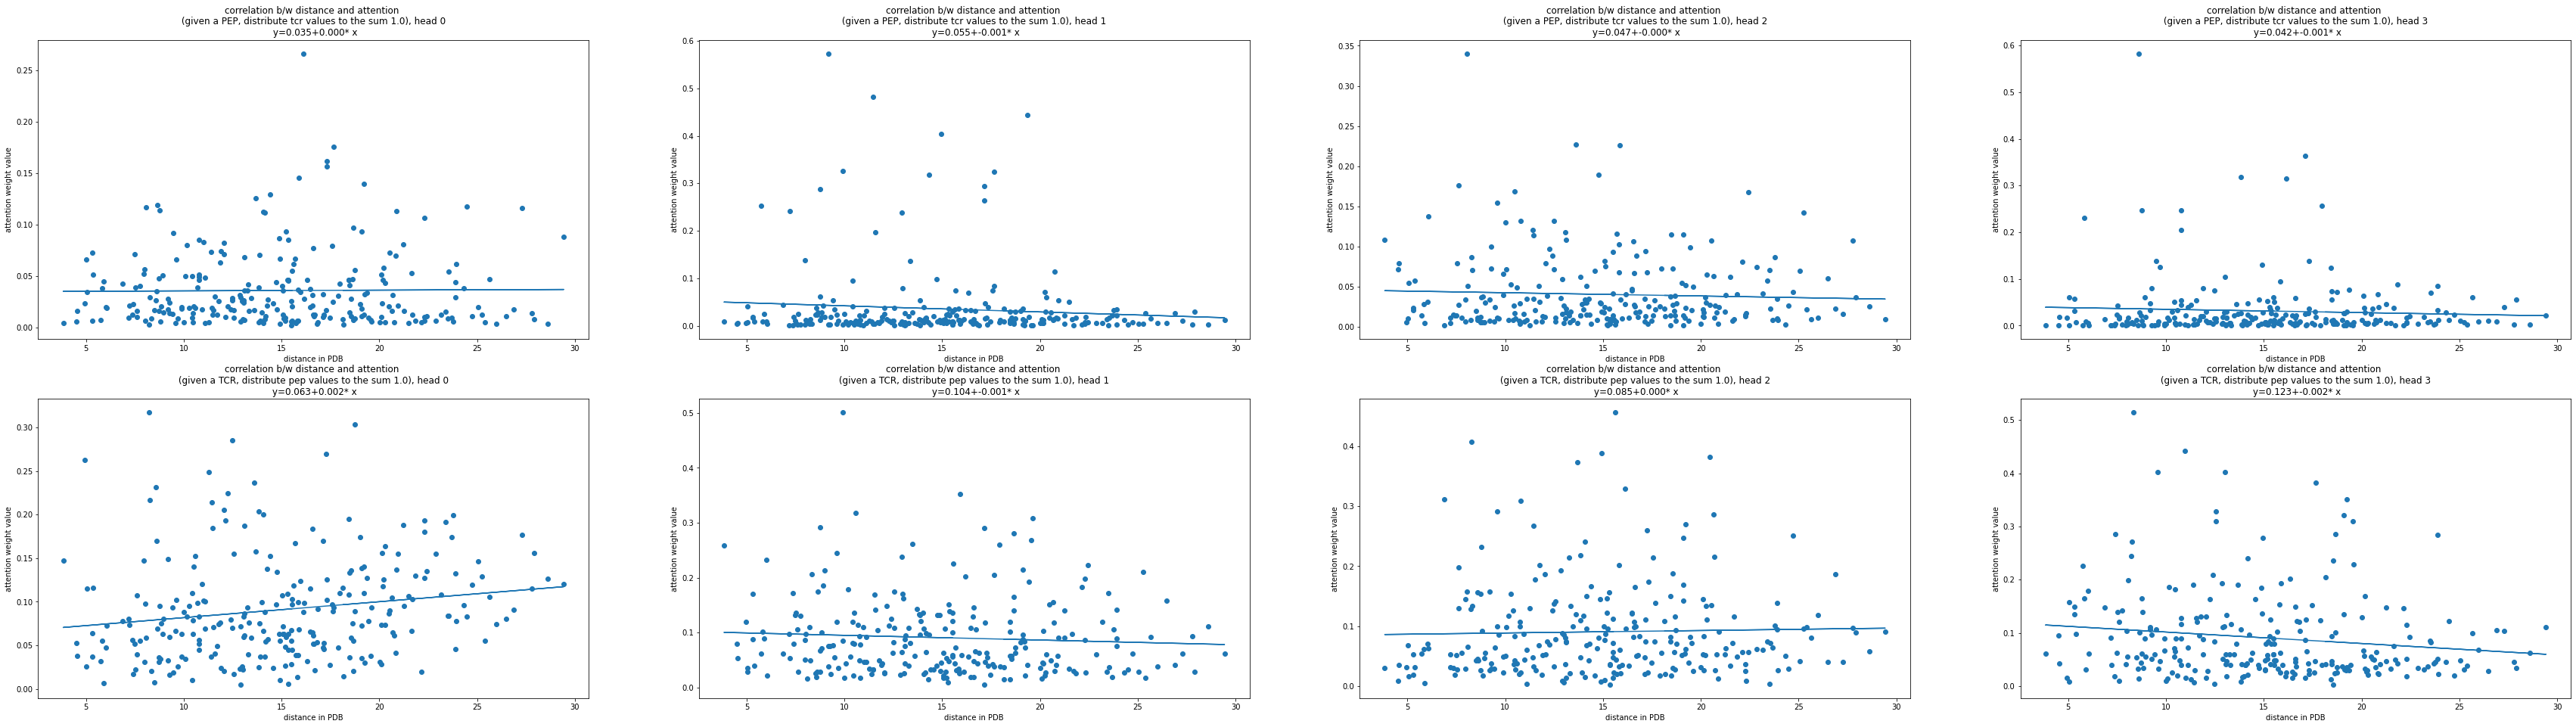

In [54]:
p = '3MV7'
HEAD_COUNT = 4

a,b,e = DICT_PDBID_2_SEQUENCES_CDR[p]
print((p,a,b,e))

def position_sorted(values):
    sorted_values = sorted(set([c.split('_')[1]+'_'+c.split('_')[0] for c in values]))
    # print(sorted_values)
    return sorted_values

fig, axs = plt.subplots(2, 4, figsize=(60,16))    
attn_output_weights1_list, attn_output_weights2_list = get_mat_from_result_tuple(
    result_tuple=DICT_PDBID_2_model_out[p], aseq=a, bseq=b, peptide=e)
plt.show()

fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for head in range(HEAD_COUNT):
    distmat_vis = DICT_PDBID_2_MELTDIST[p]
    assert all(attn_output_weights1_list[head].index == attn_output_weights2_list[head].columns)
    no_comma_position_sorted = [c for c in position_sorted(attn_output_weights1_list[head].index) if ':' not in c]
    assert position_sorted(distmat_vis['tcr'].values) == no_comma_position_sorted
    attn_output_weights1, attn_output_weights2 = attn_output_weights1_list[head], attn_output_weights2_list[head]
    merged_xy_1, merged_xy_2 = calc_melt_df(distmat_vis, attn_output_weights1, attn_output_weights2)
    show_correlation(distmat_vis, merged_xy_1, merged_xy_2, head)
plt.show()

# Sum up all the PDB

## Only 2 sigma attention

In [55]:
# # attention = pickle.load(open('attention_GILGFVFTL.pickle','rb'))

# givenTCRdistributePEP_by_head = {}
# givenPEPdistributeTCR_by_head = {}

# for hi in tqdm(range(HEAD_COUNT)):
#     givenPEPdistributeTCR_by_head[hi] = []
#     givenTCRdistributePEP_by_head[hi] = []

#     for p, (a1_by_head, a2_by_head) in DICT_PDBID_2_Atten12.items():
#         distmat_vis = DICT_PDBID_2_MELTDIST[p]
#         a1, a2 = calc_melt_df(distmat_vis, a1_by_head[hi], a2_by_head[hi])
#         a1['pdbid'] = p
#         a2['pdbid'] = p
        
#         temp1 = a1[a1['value_y'] > a1['value_y'].mean() + 5.0 * a1['value_y'].std()]
#         temp2 = a2[a2['value_y'] > a2['value_y'].mean() + 5.0 * a2['value_y'].std()]
        
#         temp1[['tcr', 'pdbid']].drop_duplicates()
        
#         givenTCRdistributePEP_by_head[hi] += [temp1]
#         givenPEPdistributeTCR_by_head[hi] += [temp2]

# fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
# for hi in range(4):
#     df1_strong_atten = pd.concat(givenTCRdistributePEP_by_head[hi])
#     df2_strong_atten = pd.concat(givenPEPdistributeTCR_by_head[hi])
#     show_correlation(distmat_vis, df1_strong_atten, df2_strong_atten, hi)


## Only 2 sigma and PosPred Attention

In [56]:
# strong_ids = [k for k,v in DICT_PDBID_2_model_out.items() if DICT_PDBID_2_model_out[k][-1]>0.5]
# # attention = pickle.load(open('attention_GILGFVFTL.pickle','rb'))

# givenTCRdistributePEP_by_head = {}
# givenPEPdistributeTCR_by_head = {}

# for hi in tqdm(range(HEAD_COUNT)):
#     givenPEPdistributeTCR_by_head[hi] = []
#     givenTCRdistributePEP_by_head[hi] = []

#     for p, (a1_by_head, a2_by_head) in DICT_PDBID_2_Atten12.items():
#         if p not in strong_ids:
#             continue
#         else:
#             distmat_vis = DICT_PDBID_2_MELTDIST[p]
#             a1, a2 = calc_melt_df(distmat_vis, a1_by_head[hi], a2_by_head[hi])
#             a1['pdbid'] = p
#             a2['pdbid'] = p

#             temp1 = a1[a1['value_y'] > a1['value_y'].mean() + 5.0 * a1['value_y'].std()]
#             temp2 = a2[a2['value_y'] > a2['value_y'].mean() + 5.0 * a2['value_y'].std()]

#             temp1[['tcr', 'pdbid']].drop_duplicates()

#             givenTCRdistributePEP_by_head[hi] += [temp1]
#             givenPEPdistributeTCR_by_head[hi] += [temp2]

# fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
# for hi in range(4):
#     df1_strong_atten = pd.concat(givenTCRdistributePEP_by_head[hi])
#     df2_strong_atten = pd.concat(givenPEPdistributeTCR_by_head[hi])
#     show_correlation(distmat_vis, df1_strong_atten, df2_strong_atten, hi)



## All attention values 

100%|██████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


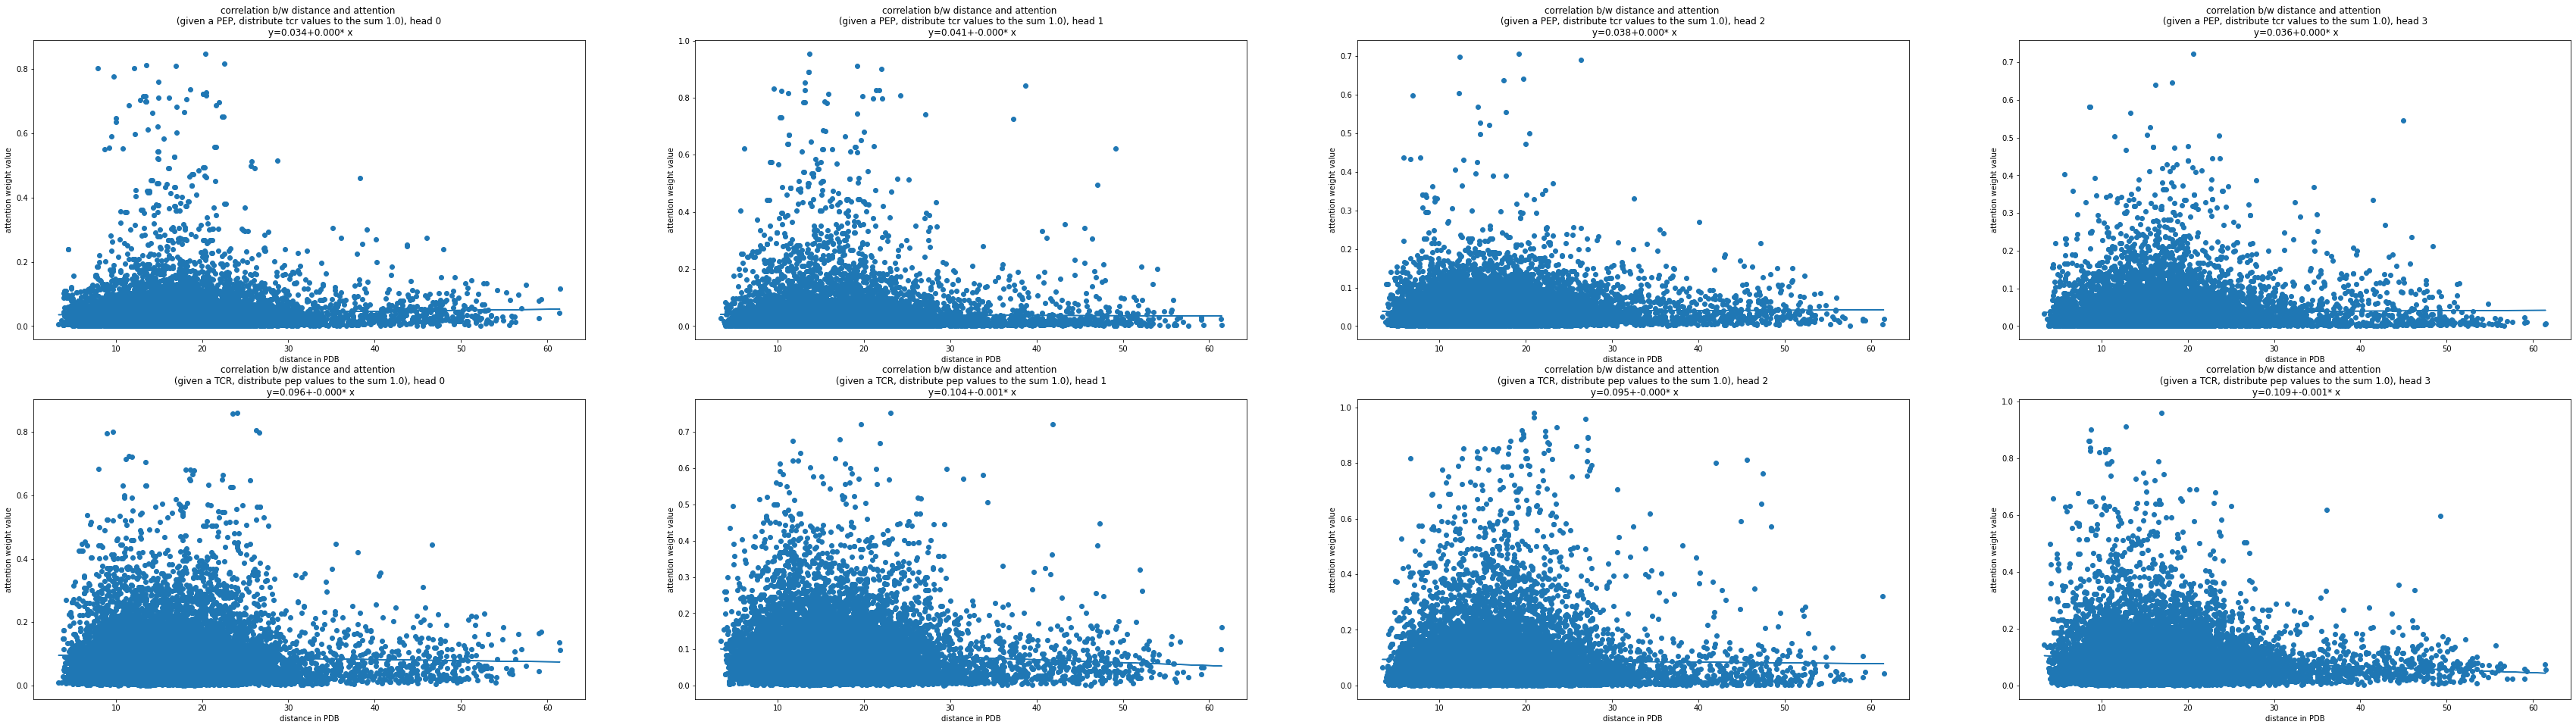

In [57]:
# attention = pickle.load(open('attention_GILGFVFTL.pickle','rb'))

givenTCRdistributePEP_by_head = {}
givenPEPdistributeTCR_by_head = {}

for hi in tqdm(range(HEAD_COUNT)):
    givenPEPdistributeTCR_by_head[hi] = []
    givenTCRdistributePEP_by_head[hi] = []

    for p, (a1_by_head, a2_by_head) in DICT_PDBID_2_Atten12.items():
        distmat_vis = DICT_PDBID_2_MELTDIST[p]
        a1, a2 = calc_melt_df(distmat_vis, a1_by_head[hi], a2_by_head[hi])
        a1['pdbid'] = p
        a2['pdbid'] = p
        
        givenTCRdistributePEP_by_head[hi] += [a1]
        givenPEPdistributeTCR_by_head[hi] += [a2]

fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for hi in range(4):
    df1 = pd.concat(givenTCRdistributePEP_by_head[hi])
    df2 = pd.concat(givenPEPdistributeTCR_by_head[hi])
    show_correlation(distmat_vis, df1, df2, hi)


## 2 Group Comparison

In [58]:
# print(df1_strong_atten.value_x.describe(), df1.value_x.describe())

In [59]:
# print(df1_strong_atten.value_y.describe(), df1.value_y.describe())

## Other

In [60]:
df1['pair_tcr_pdbid'] = df1[['tcr','pdbid']].apply(tuple, axis=1)
# .isin(df1_strong_atten[['tcr','pdbid']].apply(tuple, axis=1).apply(tuple))

In [61]:
# temp_df1_strong_atten = df1_strong_atten[['tcr','pdbid']].drop_duplicates() #.apply(tuple, axis=1)
# temp_df1_strong_atten['pair_tcr_pdbid'] = temp_df1_strong_atten.apply(tuple, axis=1)
# temp_df1_strong_atten['is_strong_atten'] = 1

In [62]:
# pd.merge(df1, temp_df1_strong_atten, on=['pair_tcr_pdbid'], how='left').drop_duplicates('pair_tcr_pdbid') #['is_strong_atten'].value_counts()

## Logs of attention values

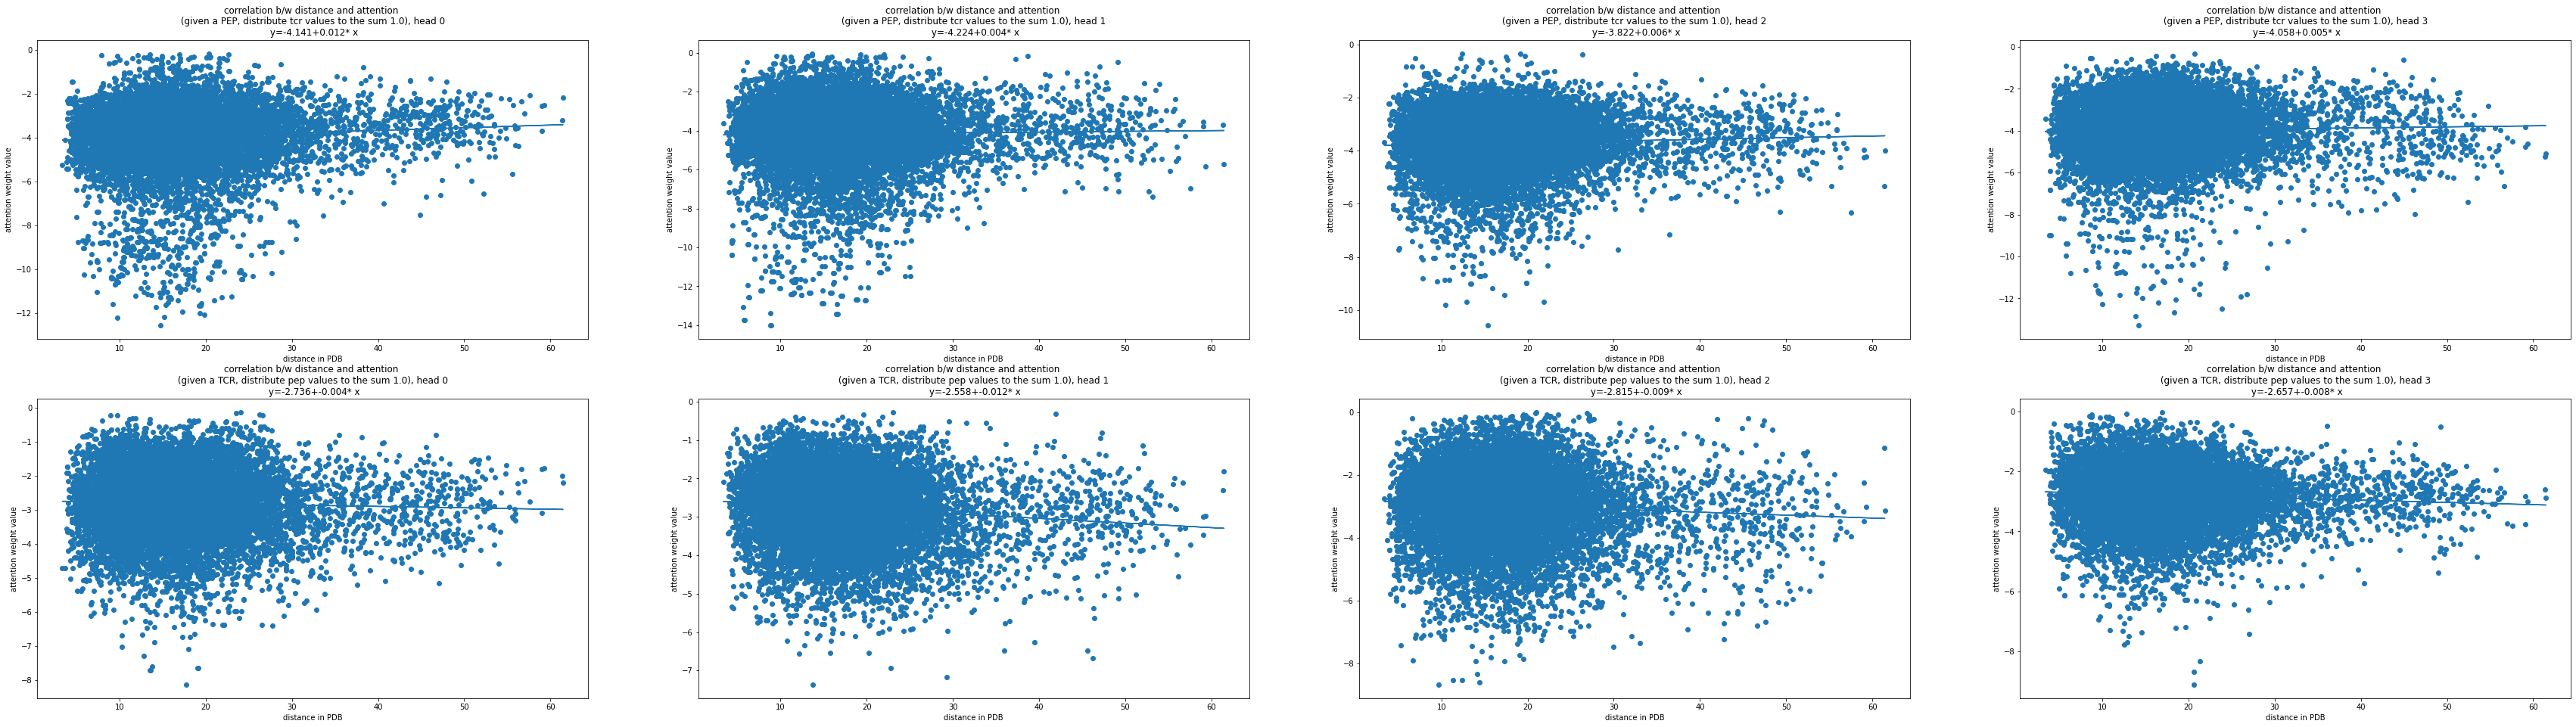

In [63]:
fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for hi in range(4):
    df1 = pd.concat(givenTCRdistributePEP_by_head[hi])
    df1['value_y'] = df1['value_y'].apply(np.log)
    df2 = pd.concat(givenPEPdistributeTCR_by_head[hi])
    df2['value_y'] = df2['value_y'].apply(np.log)
    show_correlation(distmat_vis, df1, df2, hi)


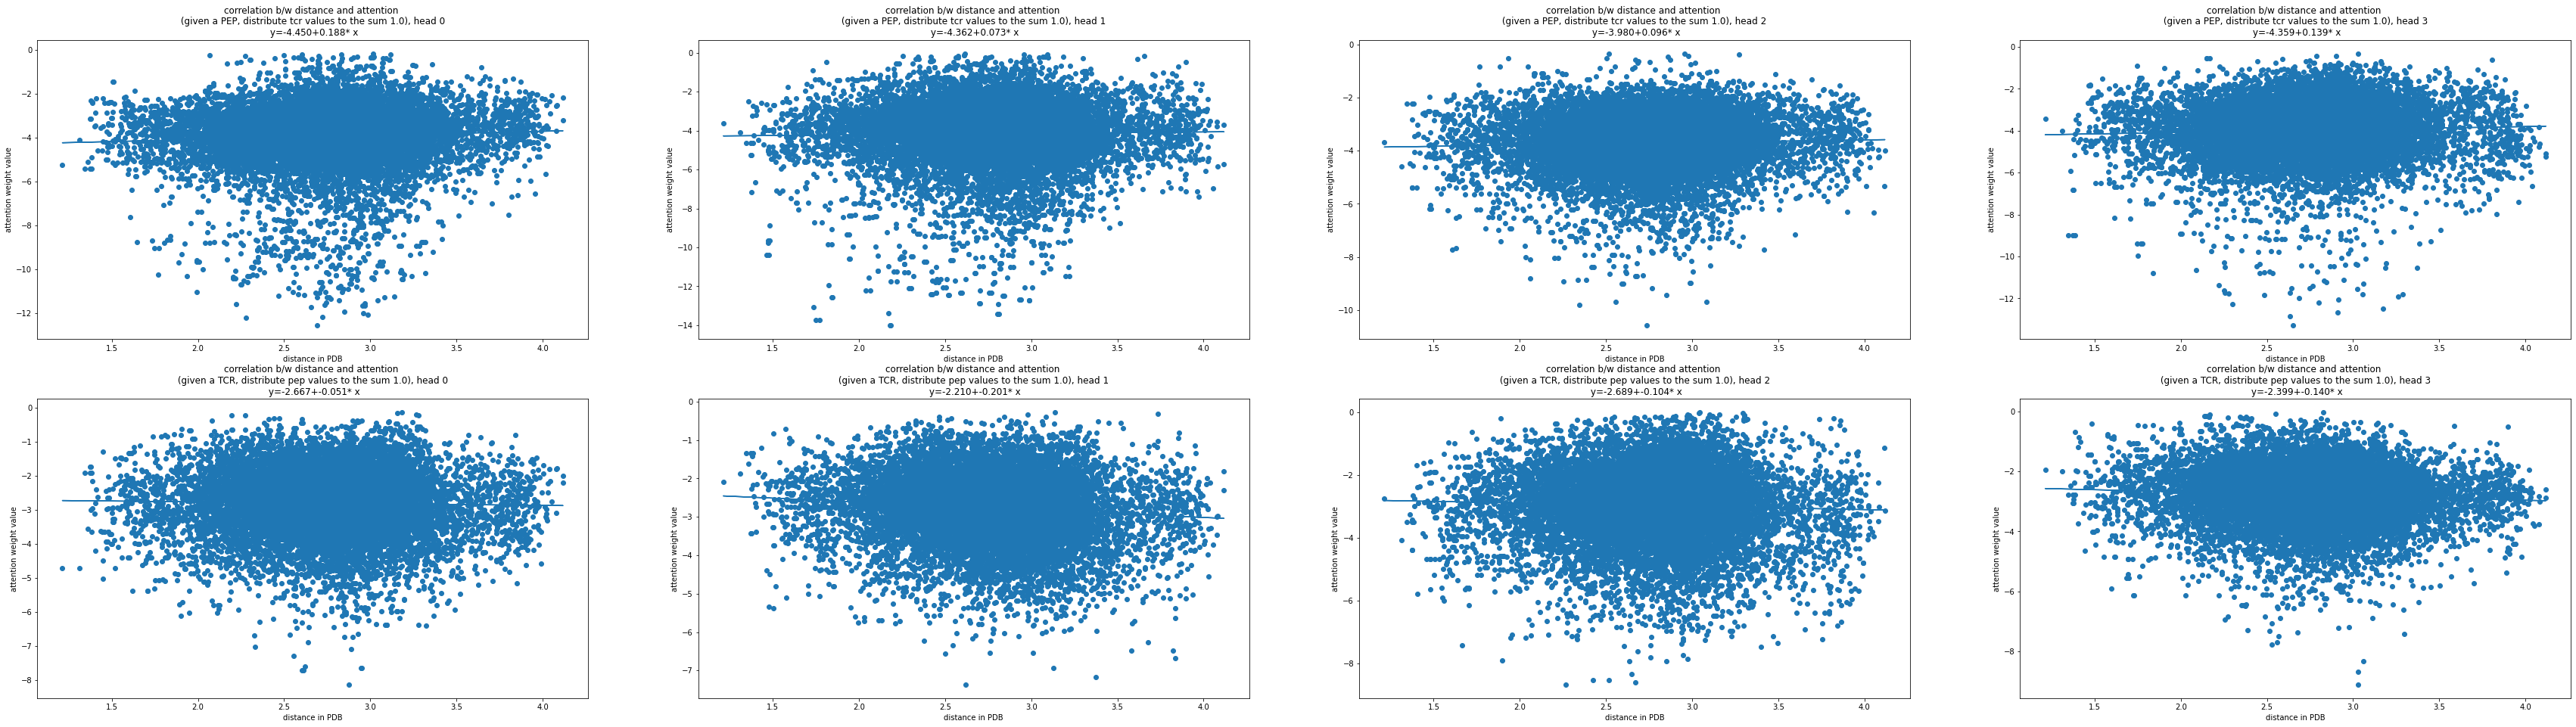

In [64]:
fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for hi in range(4):
    df1 = pd.concat(givenTCRdistributePEP_by_head[hi])
    df1['value_x'] = df1['value_x'].apply(np.log)
    df1['value_y'] = df1['value_y'].apply(np.log)
    df2 = pd.concat(givenPEPdistributeTCR_by_head[hi])
    df2['value_x'] = df2['value_x'].apply(np.log)
    df2['value_y'] = df2['value_y'].apply(np.log)
    show_correlation(distmat_vis, df1, df2, hi)


In [65]:
show_correlation(distmat_vis, df1, df2, hi)

(-2.3994364366124645,
 -0.14036811519399747,
 -4.358638729200441,
 0.13925906024685397)

# Analysis by head after summing up values

In [66]:
for head in range(4): #= 2
    df = pd.concat(givenTCRdistributePEP_by_head[head])
    

In [67]:
df.tail()

peptide   tcr    value_x   value_y pdbid
193     V_8  T_21  15.483260  0.096361  6EQA
194     V_8   T_9  27.448963  0.025839  6EQA
195     V_8   V_2  25.757448  0.040502  6EQA
196     V_8   V_4  23.091024  0.023304  6EQA
197     V_8  W_14  19.154182  0.060631  6EQA

In [68]:
print(df['value_y'].describe(percentiles=np.arange(0,1,0.1)))
percentile80 = df['value_y'].describe(percentiles=np.arange(0,1,0.1))['80%']

count    13845.000000
mean         0.090069
std          0.087867
min          0.000112
0%           0.000112
10%          0.019390
20%          0.030972
30%          0.041669
40%          0.053101
50%          0.065429
60%          0.081496
70%          0.100464
80%          0.128922
90%          0.182303
max          0.958653
Name: value_y, dtype: float64


In [69]:
df['is_strong_attention'] = df['value_y'] > percentile80
df['aa'] = df['tcr'].str.split('_').apply(lambda x: x[0])
df['pos'] = df['tcr'].str.split('_').apply(lambda x: x[1])

<AxesSubplot:xlabel='aa,is_strong_attention'>

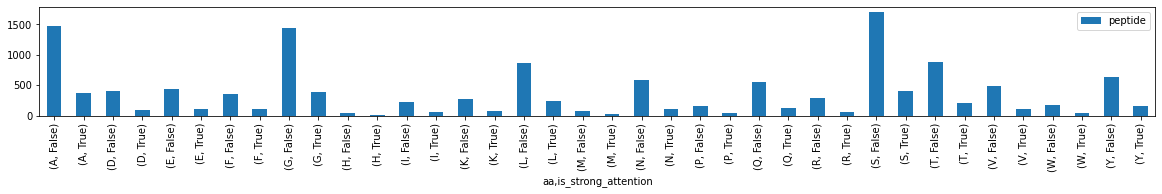

In [70]:
df.groupby(by=['aa', 'is_strong_attention']).agg(len).iloc[:,:1].plot.bar(figsize=(20,2))

<AxesSubplot:xlabel='pos,is_strong_attention'>

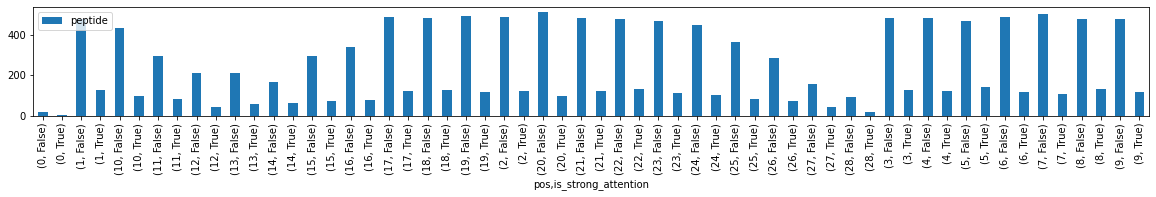

In [71]:
df.groupby(by=['pos', 'is_strong_attention']).agg(len).iloc[:,:1].plot.bar(figsize=(20,2))

# PDB Command

In [72]:
def add_commnad(Pymol_COMMAND, text):
    return Pymol_COMMAND + text + '\n'

def get_command(pdbid):
    Pymol_COMMAND = ''
    residues_chain_cdr_alpha = DICT_PDBID_2_CDRS[pdbid][0]
    residues_chain_cdr_beta = DICT_PDBID_2_CDRS[pdbid][1]

    chain2_cdr3_pdb_pos = [r.get_full_id()[3][1] for r in residues_chain_cdr_beta]
    chain1_cdr3_pdb_pos = [r.get_full_id()[3][1] for r in residues_chain_cdr_alpha]

    ALPHA_CHAIN_NAME, BETA_CHAIN_NAME, EPITOPE_CHAIN_NAME = DICT_PDBID_2_CHAINNAMES[pdbid]

    attn_output_weights1_list, attn_output_weights2_list = DICT_PDBID_2_Atten12[pdbid]
    attention_residue_index = []
    attention_residue_headnum = []
    for headi in range(4):
        atten = attn_output_weights2_list[headi]
        good_vals = (atten > (atten.values.ravel().mean() + 5.0 * atten.values.ravel().std())).any()
        attention_residue_index += [i for i,v in enumerate(good_vals.values) if v]
        attention_residue_headnum += [headi for _ in range(sum(good_vals.values))]

    residues_all = residues_chain_cdr_alpha + [None] + residues_chain_cdr_beta
    attention_residue_alpha = [residues_all[i] for i in attention_residue_index if i<len(residues_chain_cdr_alpha)]
    attention_residue_alpha_head = [attention_residue_headnum[i] for i, ri in enumerate(attention_residue_index) if ri<len(residues_chain_cdr_alpha)]
    attention_residue_beta = [residues_all[i] for i in attention_residue_index if i>=len(residues_chain_cdr_beta)]
    attention_residue_beta_head = [attention_residue_headnum[i] for i, ri in enumerate(attention_residue_index) if ri>=len(residues_chain_cdr_alpha)]
    attention_pos_alpha = [r.get_full_id()[3][1] for r in attention_residue_alpha]
    attention_pos_beta = [r.get_full_id()[3][1] for r in attention_residue_beta]

    Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'fetch {pdbid};')
    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set seq_view, 1;')
    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'bg_color white;')

    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color blue60, [ 0, 0, 110 ];')
    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color blue30, [ 0, 0, 20 ];')
    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color red60, [ 110, 0, 0 ];')
    Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color red30, [ 20, 0, 0 ];')

    if len(BETA_CHAIN_NAME)==1:
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel beta_cdr3, (chain {BETA_CHAIN_NAME} and resi {chain2_cdr3_pdb_pos[0]}:{chain2_cdr3_pdb_pos[-1]});')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set cartoon_side_chain_helper, on')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, beta_cdr3;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color blue, (chain {BETA_CHAIN_NAME} and resi {chain2_cdr3_pdb_pos[0]}:{chain2_cdr3_pdb_pos[-1]});')
    else:
        for b in BETA_CHAIN_NAME.split(', '):
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel beta_cdr3, (chain {b} and resi {chain2_cdr3_pdb_pos[0]}:{chain2_cdr3_pdb_pos[-1]});')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set cartoon_side_chain_helper, on')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, beta_cdr3;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color blue, (chain {b} and resi {chain2_cdr3_pdb_pos[0]}:{chain2_cdr3_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel beta_cdr2, (chain {BETA_CHAIN_NAME} and resi {chain2_cdr2_pdb_pos[0]}:{chain2_cdr2_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color blue60, (chain {BETA_CHAIN_NAME} and resi  {chain2_cdr2_pdb_pos[0]}:{chain2_cdr2_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel beta_cdr1, (chain {BETA_CHAIN_NAME} and resi {chain2_cdr1_pdb_pos[0]}:{chain2_cdr1_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color blue30, (chain {BETA_CHAIN_NAME} and resi resi {chain2_cdr1_pdb_pos[0]}:{chain2_cdr1_pdb_pos[-1]});')

    
    if len(ALPHA_CHAIN_NAME)==1:        
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel alpha_cdr3, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr3_pdb_pos[0]}:{chain1_cdr3_pdb_pos[-1]});')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set cartoon_side_chain_helper, on')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, alpha_cdr3;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color red, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr3_pdb_pos[0]}:{chain1_cdr3_pdb_pos[-1]});')
    else:
        for a in ALPHA_CHAIN_NAME.split(', '):
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel alpha_cdr3, (chain {a} and resi {chain1_cdr3_pdb_pos[0]}:{chain1_cdr3_pdb_pos[-1]});')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set cartoon_side_chain_helper, on')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, alpha_cdr3;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color red, (chain {a} and resi {chain1_cdr3_pdb_pos[0]}:{chain1_cdr3_pdb_pos[-1]});')

        
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel alpha_cdr2, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr2_pdb_pos[0]}:{chain1_cdr2_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color red60, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr2_pdb_pos[0]}:{chain1_cdr2_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel alpha_cdr1, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr1_pdb_pos[0]}:{chain1_cdr1_pdb_pos[-1]});')
    # Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color red30, (chain {ALPHA_CHAIN_NAME} and resi {chain1_cdr1_pdb_pos[0]}:{chain1_cdr1_pdb_pos[-1]});')
    
    if len(EPITOPE_CHAIN_NAME)==1:
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel epitope, chain {EPITOPE_CHAIN_NAME};')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, epitope;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color yellow, chain {EPITOPE_CHAIN_NAME};')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'distance polar-contact, epitope, all, mode=2;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'color black, polar-contact;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'distance pipi-pication, epitope, all, mode=5;')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color gray60, [122,122,122];')
        Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'color gray60, pipi-pication;')
    else:
        for e in EPITOPE_CHAIN_NAME.split(', '):
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel epitope, chain {e};')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'show sticks, epitope;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color yellow, chain {e};')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'distance polar-contact, epitope, all, mode=2;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'color black, polar-contact;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'distance pipi-pication, epitope, all, mode=5;')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'set_color gray60, [122,122,122];')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, 'color gray60, pipi-pication;')


    '''Attention'''
    if len(ALPHA_CHAIN_NAME)==1:
        for hi, ap in zip(attention_residue_alpha_head, attention_pos_alpha):
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel atten_a_head{hi}, (chain {ALPHA_CHAIN_NAME} and resi {ap});')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color pink, atten_a_head{hi};')
    else:
        for a in ALPHA_CHAIN_NAME.split(', '):
            for hi, ap in zip(attention_residue_alpha_head, attention_pos_alpha):
                Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel atten_a_head{hi}, (chain {a} and resi {ap});')
                Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color pink, atten_a_head{hi};')
        
    if len(BETA_CHAIN_NAME)==1:
        for hi, ap in zip(attention_residue_beta_head, attention_pos_beta):
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel atten_b_head{hi}, (chain {BETA_CHAIN_NAME} and resi {ap});')
            Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color pink, atten_b_head{hi};')
    else:
        for b in BETA_CHAIN_NAME.split(', '):
            for hi, ap in zip(attention_residue_beta_head, attention_pos_beta):
                Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'sel atten_b_head{hi}, (chain {b} and resi {ap});')
                Pymol_COMMAND = add_commnad(Pymol_COMMAND, f'color pink, atten_b_head{hi};')            
    return Pymol_COMMAND

In [73]:
DICT_PDBID_2_Atten12.keys()

dict_keys(['2VLK', '2ICW', '5WKF', '2VLJ', '3PQY', '4MJI', '4P2Q', '2YPL', '5BRZ', '6RPB', '1J8H', '4P2R', '5MEN', '3MV8', '4OZF', '3VXR', '3VXS', '4OZG', '3MV9', '5TEZ', '2J8U', '6Q3S', '4JRX', '5WLG', '3VXU', '1U3H', '4JRY', '4Z7V', '2UWE', '1LP9', '3W0W', '6AVF', '2BNQ', '4JFE', '4JFD', '3QIU', '6AVG', '2Z31', '2BNR', '5ISZ', '5KS9', '3MV7', '3MBE', '4OZH', '2NX5', '5NHT', '4QOK', '5D2L', '1D9K', '1FYT', '4P2O', '5WKH', '6EQB', '2VLR', '6EQA'])

In [74]:
PDBID = '5TEZ'
# print(get_command(pdbid=PDBID))

# Save command into file

In [75]:
len(DICT_PDBID_2_Atten12.keys())

55

In [76]:
pdbid = PDBID
# for pdbid in DICT_PDBID_2_Atten12.keys():
#     with open(f'./pymolcommand/{pdbid}.txt', 'w') as f:
#         f.writelines(get_command(pdbid))


# Save Dict_something

In [77]:
import pickle
directory = "../analysis/DICT_PDB_Result"
for name, dic in zip(
    ["DICT_PDBID_2_Atten12",
        "DICT_PDBID_2_CDRS",
        "DICT_PDBID_2_CHAINNAMES",
        "DICT_PDBID_2_DISTANCE",
        "DICT_PDBID_2_MELTDIST",
        "DICT_PDBID_2_model_out",
        "DICT_PDBID_2_RESIDUES",
        "DICT_PDBID_2_SEQUENCES_CDR",
#         "DICT_PDBID_2_STRUCTURE"
    ],
    [DICT_PDBID_2_Atten12,
        DICT_PDBID_2_CDRS,
        DICT_PDBID_2_CHAINNAMES,
        DICT_PDBID_2_DISTANCE,
        DICT_PDBID_2_MELTDIST,
        DICT_PDBID_2_model_out,
        DICT_PDBID_2_RESIDUES,
        DICT_PDBID_2_SEQUENCES_CDR,
#         DICT_PDBID_2_STRUCTURE
    ]):
    
    pickle.dump(dic, open(f'{directory}/{dt}_{name}.pickle', 'wb'))


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3656293503.py:25: ResourceWarning:

unclosed file <_io.BufferedWriter name='../analysis/DICT_PDB_Result/20220211_191954_DICT_PDBID_2_Atten12.pickle'>

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3656293503.py:25: ResourceWarning:

unclosed file <_io.BufferedWriter name='../analysis/DICT_PDB_Result/20220211_191954_DICT_PDBID_2_CDRS.pickle'>

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3656293503.py:25: ResourceWarning:

unclosed file <_io.BufferedWriter name='../analysis/DICT_PDB_Result/20220211_191954_DICT_PDBID_2_CHAINNAMES.pickle'>

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3656293503.py:25: ResourceWarning:

unclosed file <_io.BufferedWriter name='../analysis/DICT_PDB_Result/20220211_191954_DICT_PDBID_2_DISTANCE.pickle'>

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/3656293503.py:25: ResourceWarning:

unclosed file <_io.BufferedWriter 

In [78]:
pickleload(f'{directory}/{dt}_{name}.pickle')

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_14012/1420475253.py:6: ResourceWarning:

unclosed file <_io.BufferedReader name='../analysis/DICT_PDB_Result/20220211_191954_DICT_PDBID_2_SEQUENCES_CDR.pickle'>



{'2VLK': ['CAGAGSQGNLIF', 'CASSSRSSYEQYF', 'GILGFVFTL'],
 '2ICW': ['CAVSGFASALTF', 'CASGGGGTLYF', 'PKYVKQNTLKLAT'],
 '5WKF': ['CGLGDAGNMLTF', 'CASSLGQGLLYGYTF', 'GTSGSPIVNR'],
 '5NQK': ['CAGGGGADGLTF',
  'CASSQGLAGAGELFF',
  'EVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIMSIYSNGDKEDGRFTAQLNKASQYVSLLIRDSQPSDSATYLCAGGGGADGLTFGKGTHLIIQPYIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFP'],
 '2VLJ': ['CAGAGSQGNLIF', 'CASSSRSSYEQYF', 'GILGFVFTL'],
 '3PQY': ['CILSGGSNYKLTF', 'CASSFGREQYF', 'SSLENFRAYV'],
 '4MJI': ['CATDDDSARQLTF', 'CASSLTGGGELFF', 'TAFTIPSI'],
 '4P2Q': ['CAAEASNTNKVVF', 'CASSLNNANSDYTF', 'ADGLAYFRSSFKGG'],
 '2YPL': ['CAVSGGYQKVTF', 'CASTGSYGYTF', 'KAFSPEVIPMF'],
 '5BRZ': ['CAVRPGGAGPFFVVF', 'CASSFNMATGQYF', 'EVDPIGHLY'],
 '6RPB': ['CAVKSGGSYIPTF', 'CASSYLNRDSALDF', 'SLLMWITQV'],
 '1J8H': ['CAVSESPFGNEKLTF', 'CASSSTGLPYGYTF', 'PKYVKQNTLKLAT'],
 '4P2R': ['CAAEASNTNKVVF', 'CASSLNNANSDYTF', 'ANGVAFFLTPFKA'],
 '5MEN': ['CAVDSATSGTYKYIF', 'CASS